In [1]:
%matplotlib inline
from datetime import datetime
from IPython.display import Markdown
from os.path import join
from os.path import exists
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use(['ggplot'])

# Get the data

In [2]:
!mkdir -p raw # create a raw folder
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip # get zip file
!unzip -o ml-100k.zip -d raw/ # unzip the file to overwrite into raw
!rm ml-100k.zip # remove the file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  1042k      0  0:00:04  0:00:04 --:--:-- 1042k
Archive:  ml-100k.zip
  inflating: raw/ml-100k/allbut.pl   
  inflating: raw/ml-100k/mku.sh      
  inflating: raw/ml-100k/README      
  inflating: raw/ml-100k/u.data      
  inflating: raw/ml-100k/u.genre     
  inflating: raw/ml-100k/u.info      
  inflating: raw/ml-100k/u.item      
  inflating: raw/ml-100k/u.occupation  
  inflating: raw/ml-100k/u.user      
  inflating: raw/ml-100k/u1.base     
  inflating: raw/ml-100k/u1.test     
  inflating: raw/ml-100k/u2.base     
  inflating: raw/ml-100k/u2.test     
  inflating: raw/ml-100k/u3.base     
  inflating: raw/ml-100k/u3.test     
  inflating: raw/ml-100k/u4.base     
  inflating: raw/ml-100k/u4.test     
  inflating: raw/ml-100k/u5.base     
  inflating: raw/ml-100k/u5.test     
  inflating: raw/

In [2]:
# read the data
ratings = pd.read_csv('raw/ml-100k/u.data', sep = '\t', header = None, 
                      names = ['user_id', 'movie_id', 'rating', 'timestamp'])
ratings['timestamp'] = ratings['timestamp'].apply(datetime.fromtimestamp)
ratings['year'] = ratings['timestamp'].dt.year
ratings['month'] = ratings['timestamp'].dt.month
ratings.head()

# sort data by timestamp
ratings = ratings.sort_values('timestamp')
ratings

,user_id,movie_id,rating,timestamp,year,month
214,259,255,4,1997-09-19 20:05:10,1997,9
83965,259,286,4,1997-09-19 20:05:27,1997,9
43027,259,298,4,1997-09-19 20:05:54,1997,9
21396,259,185,4,1997-09-19 20:06:21,1997,9
82655,259,173,4,1997-09-19 20:07:23,1997,9
...,...,...,...,...,...,...
46773,729,689,4,1998-04-22 16:10:38,1998,4
73008,729,313,3,1998-04-22 16:10:38,1998,4
46574,729,328,3,1998-04-22 16:10:38,1998,4
64312,729,748,4,1998-04-22 16:10:38,1998,4


The ratings dataset is composed with `user_id`, `item_id` and `rating` with time. We could explore more information about this dataset.


# EDA

## 1. How are ratings distributed?

The mode of rating is about 4. The shape is kind of left-skewness. 

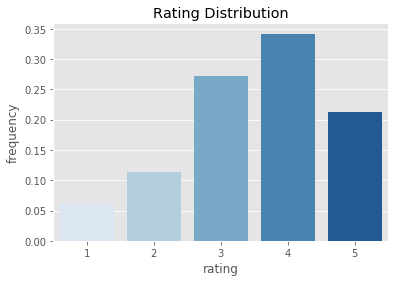

In [3]:
rating_count = (
    ratings['rating'].
    value_counts(normalize = True, sort=False).
    reset_index().
    rename(columns = {'index' : 'rating', 'rating': 'frequency'})
)

ax = sns.barplot(x = 'rating', y = 'frequency', palette = 'Blues', data = rating_count)
ax.set_title('Rating Distribution')
# plt.savefig('EDA_rating_dist.png', dpi=300)
plt.show()

## 2. The histogram of the number of user ratings

Most users wrote limited numbers(< 100) of reviews.

In [4]:
len(set(ratings['user_id']))

943

In [5]:
ratings.groupby('user_id')['movie_id'].count()

user_id
1      272
2       62
3       54
4       24
5      175
      ... 
939     49
940    107
941     22
942     79
943    168
Name: movie_id, Length: 943, dtype: int64

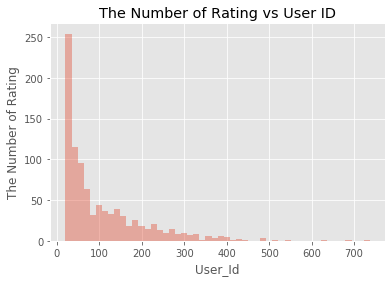

In [6]:
g = sns.distplot(ratings.groupby('user_id')['movie_id'].count(), kde = False, bins = 50)
g.set_title('The Number of Rating vs User ID')
g.set_xlabel('User_Id')
g.set_ylabel('The Number of Rating');
# plt.savefig('EDA_Rating vs User_id.png', dpi=300);

## 3. How many ratings were submitted per month?

,month,rating
year,,
1997,September,6863
1997,October,10313
1997,November,24137
1997,December,11631
1998,January,14237
1998,February,10946
1998,March,13034
1998,April,8839


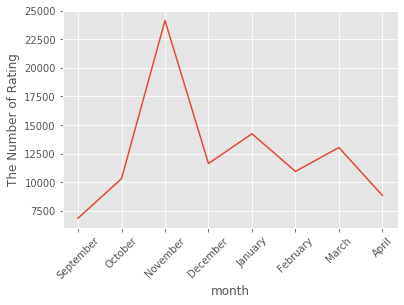

In [7]:
import calendar

rating_time = ratings.groupby(['year', 'month'])['rating'].count()
rating_time = rating_time.reset_index(level=1)
rating_time['month'] = [calendar.month_name[i] for i in rating_time['month']]
display(rating_time)

ax = sns.lineplot(x = 'month', y = 'rating',data = rating_time, sort = False)
ax.set_ylabel('The Number of Rating')
plt.xticks(rotation=45);
# plt.savefig('EDA_RatingOverTime', dpi=300);

In 1997 November, the number of rating is higher than others; other months have constant euqally numbers of rating.

In [8]:
ratings['movie_id'].nunique()

1682

## 4. How consistent are the average ratings over time?

The average ratings were fairly consistent around 3.5. The lack of change over time might simplify future models.

,month,mean,std
year,,,
1997,September,3.544368,1.089431
1997,October,3.592844,1.099640
1997,November,3.557692,1.110484
1997,December,3.580690,1.110414
1998,January,3.395519,1.185868
1998,February,3.460259,1.129901
1998,March,3.545113,1.110692
1998,April,3.582306,1.140497


/Users/Aaron/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


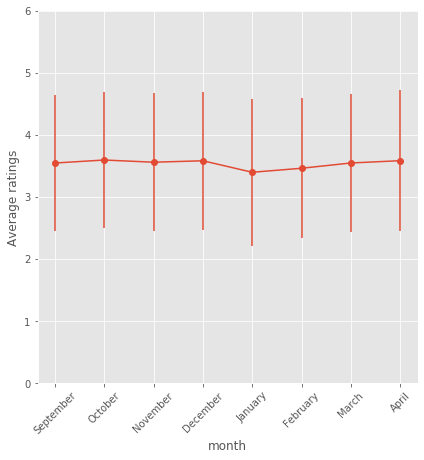

In [9]:
rating_avg = ratings.groupby(['year', 'month'])['rating'].agg([np.mean, np.std])
rating_avg = rating_avg.reset_index(level = 1)
rating_avg['month'] = [calendar.month_name[i] for i in rating_avg['month']]
display(rating_avg)

g = sns.FacetGrid(rating_avg, size=6, ylim = (0,6))
ax = g.map(plt.errorbar,'month', 'mean', 'std', marker="o")
ax.set(xlabel = 'month', ylabel = 'Average ratings')
plt.xticks(rotation=45);

,year,month,Rating,std
Date,,,,
1997-09-01,1997,9,3.544368,1.089431
1997-10-01,1997,10,3.592844,1.099640
1997-11-01,1997,11,3.557692,1.110484
1997-12-01,1997,12,3.580690,1.110414
1998-01-01,1998,1,3.395519,1.185868
1998-02-01,1998,2,3.460259,1.129901
1998-03-01,1998,3,3.545113,1.110692
1998-04-01,1998,4,3.582306,1.140497


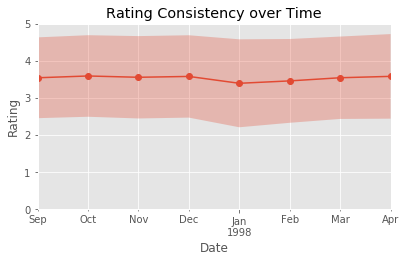

In [10]:
month_counts = ratings.groupby(['year', 'month'])['rating'].agg([np.mean, np.std])
month_counts = month_counts.rename(index=str, columns={'mean': 'Rating'})
month_counts = month_counts.reset_index()
month_counts['Date'] = month_counts[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
month_counts = month_counts.set_index('Date', drop=True)
display(month_counts)
month_counts['Rating'].plot(style='o-')
plt.fill_between(month_counts.index,
                 month_counts['Rating'] - month_counts['std'],
                 month_counts['Rating'] + month_counts['std'],
                 alpha=0.3,
                )
plt.ylim([0, 5])
plt.ylabel('Rating')
plt.gca().grid(which='minor')
plt.title('Rating Consistency over Time')
plt.tight_layout(pad=2)
# plt.savefig('EDA_Rating_scores', dpi=900, figsize = (8, 8))
plt.show()

## 4. How quickly do the movie and user bases grow over time?

The numbers of users and movies increase linearly over time.

,user_id,movie_id,rating,timestamp,year,month,Date
214,259,255,4,1997-09-19 20:05:10,1997,9,1997-09-01
83965,259,286,4,1997-09-19 20:05:27,1997,9,1997-09-01
43027,259,298,4,1997-09-19 20:05:54,1997,9,1997-09-01
21396,259,185,4,1997-09-19 20:06:21,1997,9,1997-09-01
82655,259,173,4,1997-09-19 20:07:23,1997,9,1997-09-01


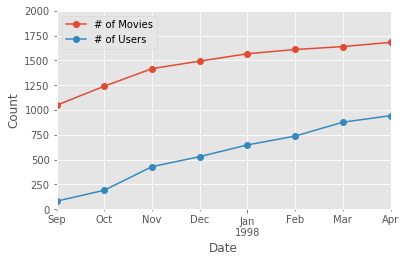

In [11]:
ratings['Date'] = ratings[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
display(ratings.head())
n_users = []
n_movies = []
dates = np.unique(ratings['Date'])
for date in dates:
    n_users.append(ratings[ratings['Date'] <= date]['user_id'].nunique())
    n_movies.append(ratings[ratings['Date'] <= date]['movie_id'].nunique())
df_users = pd.DataFrame({'Date': dates, '# of Users': n_users}).set_index('Date')
df_movies = pd.DataFrame({'Date': dates, '# of Movies': n_movies}).set_index('Date')
fig, ax = plt.subplots()
df_movies['# of Movies'].plot(style='o-', ax=ax)
df_users['# of Users'].plot(style='o-', ax=ax)
plt.ylabel('Count')
plt.ylim([0, 2000])
ax.grid(which='minor')
plt.tight_layout()
plt.legend()
plt.tight_layout(pad=2)
# plt.savefig('EDA_increase_num', dpi=900, figsize = (8, 8))
plt.show()

## 5. What is the sparsity of the user/movie matrix?

The maximum number of movie reviews from a single user is 737 that is less than the total number of movies(1682). This indicates that no one could evaluate all movies in our dataset.

In [12]:
ratings.groupby('user_id')['rating'].count().max()

737

In [13]:
ratings['movie_id'].nunique()

1682

The maximum reviews of a movie(id = 50) is 583 that is less than the number of users(943). This indicates every single movie is not evaluated by every user in our dataset.

In [14]:
ratings.groupby('movie_id')['rating'].count().max()

583

In [15]:
ratings['user_id'].nunique()

943

These facts point out that data sparsity arises in our dataset from the phenomenon that users in general rate only a limited number of movies. Generally, we need to address sparisty problem in most collaborative filtering which generates recommender systems. The primary reason is that a collaborative filtering algorithms are mainly based on similarity measures computed over the co-rated set of items, the large levels of sparsity can lead to less accuracy and can challenge the predictions or recommendations of the collaborative filtering (CF)systems[1]. Also, the another problem is the scalability problem, which is caused by requiring the large amount of training data in applying our algorithms.

The sparsity formular is $$1 - \frac{\rm{Number \ of \ ratings}}{\rm{Number \ of \ users * Number \ of \ movies}}$$

By calculation, the sparsity in our dataset is about 93.7%.  

[1]https://link.springer.com/chapter/10.1007/978-3-642-35314-7_13

In [16]:
1 - ratings['rating'].count() / (ratings['user_id'].nunique() * ratings['movie_id'].nunique())

0.9369533063577546

Suppose we create a rating matrix R with dimension $n_{users}$ * $m_{movie}$ where each cell $r_{ij}$ is the rating by $i$ user and $j$ movie. If with the sparsity problem, the matrix might contain many empty cells that users only respectively rated a few number of 1682 movies. 


Here's one way to visualize the sparsity. The plot below shows a single, tiny black square for every user/movie combination we have. If everyone rated every movie, you'd see a solid black rectangle. Instead what we see is a lot of white--lots of user/movie combinations for which we don't have a rating (yet). You especially see a lot of white areas in the top right corner. This is probably because early raters had access to fewer movies to rate, and new users progressively had more movies to rate as they were added to the system.

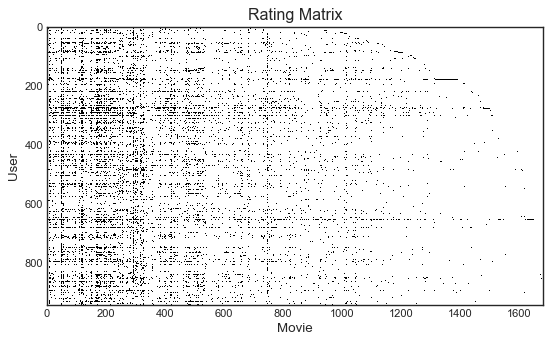

In [18]:
rating_matrix = (
        pd.pivot_table(
            data=ratings,
            values='rating',
            index='user_id',
            columns='movie_id'
        )
        .fillna(0)
        .values
    )


figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
with plt.style.context('seaborn-white'):
    rating_matrix_binary = rating_matrix > 0
    plt.imshow(rating_matrix_binary)
    plt.xlabel('Movie')
    plt.ylabel('User')
    plt.title('Rating Matrix')
    plt.savefig('R', dpi=900, figsize = (8, 8))
    plt.show()